# AX=YB
This notebook shows the process of calibrating the extrinsic parameters between the Vicon marker coordinate frame installed on an object with respect to the object CAD coordinate frame. We use the ICG 3D tracker algorithm to track the 3D pose of the object through its pointcloud observation and the ROS2 vicon bridge to get the pose of the markers installed on it.

## Instantiate the Interfaces
### ROS2

In [ ]:
from SimpleHandEye.interfaces.utils import addFoxyPath
addFoxyPath('/opt/ros/foxy')

In [ ]:
from SimpleHandEye.interfaces.ros2 import ROS2TFInterface
import rclpy
rclpy.init()    
tf_interface = ROS2TFInterface('world', 'base_link')

In [ ]:
tf_interface.getPose()

### ROS1

In [ ]:
from SimpleHandEye.interfaces.utils import addNoeticPath
addNoeticPath('/opt/ros/noetic')

In [ ]:
from SimpleHandEye.interfaces.ros import ROSTFInterface, initRosNode
initRosNode()
tf_interface = ROSTFInterface('vicon/world', 'vicon/wall/wall')

In [ ]:
tf_interface.getPose()

### April-Tag Tracker

In [ ]:
from SimpleHandEye.interfaces.cameras import RealSenseCamera
import cv2

def showImage(color_frame, depth_frame, ir1_frame, ir2_frame):
    cv2.imshow('image', color_frame)
    cv2.waitKey(33)

camera = RealSenseCamera(callback_fn=showImage)

intrinsics_params = camera.getIntrinsics()
K = intrinsics_params['RGB']['K']
D = intrinsics_params['RGB']['D']

In [ ]:
from SimpleHandEye.interfaces.apriltag import ApriltagTracker
tracker = ApriltagTracker(tag_size=0.172,
                          intrinsic_matrix=K,
                          distortion_coeffs=D)

tracker.getPose(camera.color_frame, tag_id=0)

In [ ]:
import time
from SimpleHandEye.interfaces.ros import ROSTFPublisher
tracker_tf_publisher = ROSTFPublisher('camera', 'tag0')

for _ in range(100):
    T = tracker.getPose(camera.color_frame, tag_id=0)
    if T is not None:
        tracker_tf_publisher.publish(T)
        time.sleep(0.3) 

## Instantiate the Solver

In [ ]:
from SimpleHandEye.solvers import OpenCVSolver
solver = OpenCVSolver()

## Collect The Calibration Dataset

In [ ]:
import ipywidgets as widgets
import numpy as np
from IPython.display import display
from pprint import pprint
from IPython.display import clear_output
np.set_printoptions(suppress=True, precision=3)

# The dataset
A_list = []
B_list = []
apriltag_info = []
apriltag_imgs_raw = []
apriltag_imgs_udist = []
def on_sample_clicked(b):
    A = tf_interface.getPose()
    img = camera.color_frame
    info = tracker.getPoseAndCorners(img, tag_id=0)
    B = info['pose']
    apriltag_info.append(info)
    apriltag_imgs_raw.append(img)
    apriltag_imgs_udist.append(tracker.undistortImage(img))
    print("A=")
    pprint(A)
    print("B=")
    pprint(B)
    # if A is not None and B is not None:
    A_list.append(A)
    B_list.append(B)
    print("*************")

def on_compute_clicked(b):
    try:
        X,Y = solver.solve(A_list, B_list)
        clear_output(wait=True)
        print("X=")
        pprint(X)
        print("Y=")
        pprint(Y)
    except:
        print("Bad dataset, please record again")
        A_list.clear()
        B_list.clear()
        

sample_button = widgets.Button(description="Sample")
compute_button = widgets.Button(description="Compute")

sample_button.on_click(on_sample_clicked)
compute_button.on_click(on_compute_clicked)
display(sample_button)
display(compute_button)

In [ ]:
X, Y = solver.solve(A_list, B_list)

In [ ]:
camera.close()

In [ ]:
import pickle
with open('dataset.pkl', 'wb') as f:
    data = {
        'A_list': A_list,
        'B_list': B_list,
        'apriltag_info': apriltag_info,
        'apriltag_imgs_raw': apriltag_imgs_raw,
        'apriltag_imgs_udist': apriltag_imgs_udist,
        'camera_matrix': K, 
        'distortion_coeffs': D,
        'X': X,
        'Y': Y
    }
    pickle.dump(data, f)

## Export the Result

In [ ]:
wall_T_tag = X
world_T_camera = Y

In [ ]:
from SimpleHandEye.exporters import export2ROS
export2ROS(wall_T_tag, 'vicon/wall/wall', 'tag', 'wall_T_tag_publisher.launch')
export2ROS(world_T_camera, 'vicon/world', 'camera', 'world_T_camera_publisher.launch')

# Reprojection Error Minimization

## Visualization and Analysis

In [6]:
import symforce as sf
import pickle 
with open('dataset/simple_handeye_dataset.pkl', 'rb') as f:
    data = pickle.load(f)

data.keys()

dict_keys(['A_list', 'B_list', 'apriltag_info', 'apriltag_imgs_raw', 'apriltag_imgs_udist', 'camera_matrix', 'distortion_coeffs', 'X', 'Y'])

In [152]:
import numpy as np
import matplotlib.pyplot as plt

imgs = data['apriltag_imgs_udist']
corners = [info['corners'] for info in data['apriltag_info']]
vicon_T_marker = data['A_list']
camera_T_tag = data['B_list']
marker_T_tag = data['X']
vicon_T_cam = data['Y']
K = data['camera_matrix']
cam_T_vicon = np.linalg.inv(vicon_T_cam)

tag_size = 0.172
tag_corners = np.array([[-tag_size/2, tag_size/2, 0],
                        [ tag_size/2, tag_size/2, 0],
                        [ tag_size/2, -tag_size/2, 0],
                        [-tag_size/2,  -tag_size/2, 0]])
tag_corners = np.hstack([tag_corners, np.ones((4,1))]).T

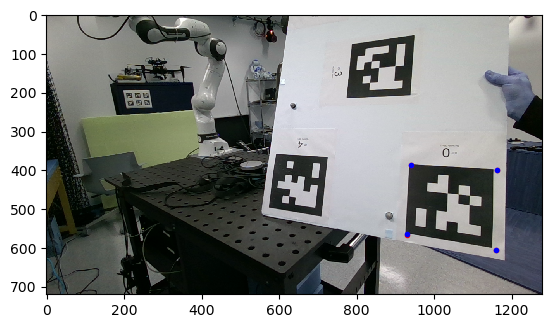

In [155]:
errors = []
for n in range(len(corners)):
    pixel_pos = corners[n].T
    cam_p = cam_T_vicon@vicon_T_marker[n]@marker_T_tag@tag_corners
    pixel_pos_hat = K@cam_p[0:3,:]
    pixel_pos_hat = (pixel_pos_hat/pixel_pos_hat[2,:])[0:2,:]
    e = (pixel_pos-pixel_pos_hat).mean(axis=1)
    errors.append(e)
errors = np.array(errors)
plt.imshow(imgs[n])
plt.plot(pixel_pos[0,:], pixel_pos[1,:], 'r.')
plt.plot(pixel_pos_hat[0,:], pixel_pos_hat[1,:], 'b.')


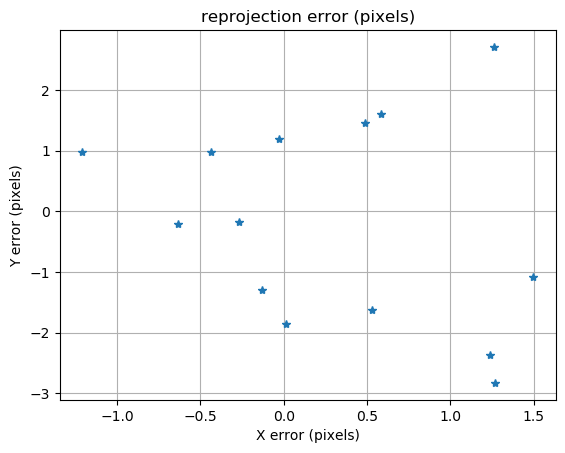

In [156]:
plt.plot(errors[:,0],errors[:,1], '*')
plt.title('reprojection error (pixels)')
plt.xlabel('X error (pixels)')
plt.ylabel('Y error (pixels)')
plt.grid(True)

In [ ]:
errors.mean()

## Optimization with SymForce

In [7]:
import symforce
symforce.set_epsilon_to_symbol()

In [8]:
import symforce.symbolic as sf
vicon_T_marker = sf.Pose3.symbolic('vicon_T_marker')
camera_T_tag = sf.Pose3.symbolic('camera_T_tag')
marker_T_tag = sf.Pose3.symbolic('marker_T_tag')
cam_T_vicon = sf.Pose3.symbolic('cam_T_vicon')
K = sf.Matrix33.symbolic('K')
w_p = sf.V3.symbolic(f'p')

cam_p = cam_T_vicon*vicon_T_marker*marker_T_tag*w_p
pixel_pos_hat = K*cam_p

In [210]:
import numpy as np
from symforce.values import Values
tag_size = 0.172

tag_corners = [[-tag_size/2, tag_size/2, 0],
               [ tag_size/2, tag_size/2, 0],
               [ tag_size/2, -tag_size/2, 0],
               [-tag_size/2,  -tag_size/2, 0]]

initial_values = Values(

                vicon_T_marker = [sf.Pose3(R = sf.Rot3.from_rotation_matrix(T[0:3,0:3]),
                                                t = sf.V3(T[0:3,-1]))\
                                                for T in data['A_list'] ],

                cam_T_tag = [sf.Pose3(R = sf.Rot3.from_rotation_matrix(T[0:3,0:3]),
                                                t = sf.V3(T[0:3,-1]))\
                                                for T in data['B_list'] ],

                z_pix = [[sf.V2(info['corners'][i,:]) for i in range(len(info['corners']))] for info in data['apriltag_info']],
                
                K = sf.Matrix33(data['camera_matrix']),
                tag_p = [sf.V3(np.array(c)) for c in tag_corners],
                
                cam_T_vicon = sf.Pose3(R = sf.Rot3.from_rotation_matrix(np.linalg.inv(data['Y'])[0:3,0:3]),
                                       t = sf.V3(np.linalg.inv(data['Y'])[0:3,-1])),

                marker_T_tag = sf.Pose3(R = sf.Rot3.from_rotation_matrix(data['X'][0:3,0:3]),
                                        t = sf.V3(data['X'][0:3,-1])),
                epsilon = sf.numeric_epsilon
)

In [240]:
from symforce import typing as T

def reprojection_residuals(cam_T_vicon: sf.Pose3,
                           marker_T_tag: sf.Pose3,
                           z_pix: sf.V2,
                           vicon_T_marker: sf.Pose3,
                           tag_p: sf.V3,
                           K: sf.Matrix33,
                           epsilon:sf.Scalar):
    
    cam_p = cam_T_vicon*vicon_T_marker*marker_T_tag*tag_p
    pixel_pos_hat = K*cam_p
    pixel_pos_hat = (pixel_pos_hat/pixel_pos_hat[2,:])[0:2]
    return sf.V1((pixel_pos_hat[0:2]-z_pix).norm(epsilon=epsilon)/10)

def AXYB_residual(vicon_T_marker: sf.Pose3,
                  cam_T_tag: sf.Pose3,
                  marker_T_tag: sf.Pose3,
                  cam_T_vicon: sf.Pose3,
                  epsilon: sf.Scalar):
    tangent_error = (vicon_T_marker*marker_T_tag).local_coordinates((cam_T_vicon.inverse()*cam_T_tag), epsilon=epsilon)
    return T.cast(sf.V6, sf.V6(tangent_error)) 

In [291]:
for i in range(len(data['apriltag_info'])):
    for j in range(4):    
        print(
        reprojection_residuals(
            initial_values['cam_T_vicon'],
            initial_values['marker_T_tag'],
            initial_values[f'z_pix[{i}][{j}]'],
            initial_values[f'vicon_T_marker[{i}]'],
            initial_values[f'tag_p[{j}]'],
            initial_values['K'],
            initial_values['epsilon']
        )
        )

[0.109190381879567]

[0.215895746164221]

[0.0868803690008107]

[0.201919903162221]

[0.195256358463876]

[0.209871573172688]

[0.118440669272167]

[0.136160968979957]

[0.0140736090069282]

[0.0624831676086976]

[0.101957206883183]

[0.0678244267063801]

[0.155092200673361]

[0.0803953297963426]

[0.249460374587071]

[0.314898967318389]

[0.269521381870655]

[0.250020425506763]

[0.127769213899598]

[0.137415338768915]

[0.025680320041262]

[0.0524316079684331]

[0.111607069351165]

[0.183213452484117]

[0.148554022562345]

[0.0317654239672438]

[0.161832486176666]

[0.249099279020623]

[0.25949149146557]

[0.274155115535837]

[0.197760053078]

[0.383919410569731]

[0.165881117110541]

[0.0087375177607986]

[0.280737060285495]

[0.240144999552117]

[0.314183674537489]

[0.361085875337219]

[0.199695427091423]

[0.37908358012271]

[0.420113517190453]

[0.150124782063147]

[0.494929578730993]

[0.294634981645035]

[0.141132646365102]

[0.191347361198306]

[0.130749470147846]

[0.2330625

In [182]:
for i in range(len(data['apriltag_info'])):
    print(AXYB_residual(
        initial_values[f'vicon_T_marker[{i}]'],
        initial_values[f'cam_T_tag[{i}]'],
        initial_values['marker_T_tag'],
        initial_values['cam_T_vicon'],
        initial_values['epsilon']
        ))

[-0.0224239718133396]
[0.0196825705556033]
[-0.000189570173980087]
[-0.00132755530000001]
[0.0021989307371042]
[-0.000665037208146924]

[-0.00123976637511144]
[0.0153447745193651]
[0.000617413399268035]
[0.00430832161932937]
[-0.00256953146183614]
[-0.0022796426028584]

[0.00154598779713764]
[-0.0163574493179817]
[0.00275269146152401]
[0.00156395703629236]
[-0.00104654152830763]
[-0.00018995655656262]

[0.0060260317264606]
[0.00618043340737984]
[-0.00384141555343411]
[-0.00101021587994532]
[-0.000502129208524327]
[0.00118123369562428]

[-0.0166978942118299]
[-0.00978275485385075]
[0.0021313755036343]
[-0.00165875255404069]
[0.00191742173293719]
[0.00136788782728625]

[-0.01584943287336]
[0.00130471189209834]
[0.00265444399330357]
[0.00110871827050846]
[-0.000233697099141228]
[-0.000129896544523778]

[0.00828028779025455]
[-0.000253127388608702]
[-0.00240813924614185]
[0.000708183507312971]
[-0.00161089204000975]
[0.000550692029724686]

[0.0380762675655217]
[0.0154126568825153]
[-0.0009

In [300]:
from symforce.opt.factor import Factor
factors = []
i=0
for i in range(len(data['apriltag_info'])):
    for j in range(4):
       factors.append(
              Factor(
                     residual=reprojection_residuals,
                     keys=[ "cam_T_vicon",
                            "marker_T_tag",
                            f'z_pix[{i}][{j}]',
                            f'vicon_T_marker[{i}]',
                            f'tag_p[{j}]',
                            "K",
                            "epsilon"],
                     )
       )

       factors.append(
              Factor(
                     residual=AXYB_residual,
                     keys=[ f'vicon_T_marker[{i}]',
                            f'cam_T_tag[{i}]',
                            "marker_T_tag",
                            "cam_T_vicon",
                            "epsilon"],
                     )
       )

In [308]:
from symforce.opt.optimizer import Optimizer

optimizer = Optimizer(
    factors=factors,
    optimized_keys=["marker_T_tag", "cam_T_vicon"] + \
                   [f'cam_T_tag[{i}]' for i in range(len(data['apriltag_info']))],
    # So that we save more information about each iteration, to visualize later:
    debug_stats=True,
    params=Optimizer.Params(verbose=True, initial_lambda=1e3, lambda_down_factor=1 / 10.0, lambda_upper_bound=1e8, iterations=1000, early_exit_min_reduction=1e-4)
)

In [309]:
result = optimizer.optimize(initial_values)

[2023-12-15 21:26:49.699] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+03, error prev/linear/new: 1.316/0.000/0.960, rel reduction: 0.27054
[2023-12-15 21:26:49.714] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e+02, error prev/linear/new: 0.960/0.000/0.678, rel reduction: 0.29346
[2023-12-15 21:26:49.729] [info] LM<sym::Optimize> [iter    2] lambda: 1.000e+01, error prev/linear/new: 0.678/0.000/0.886, rel reduction: -0.30693
[2023-12-15 21:26:49.745] [info] LM<sym::Optimize> [iter    3] lambda: 4.000e+01, error prev/linear/new: 0.678/0.000/0.833, rel reduction: -0.22772
[2023-12-15 21:26:49.760] [info] LM<sym::Optimize> [iter    4] lambda: 1.600e+02, error prev/linear/new: 0.678/0.000/0.728, rel reduction: -0.07307
[2023-12-15 21:26:49.775] [info] LM<sym::Optimize> [iter    5] lambda: 6.400e+02, error prev/linear/new: 0.678/0.000/0.634, rel reduction: 0.06522
[2023-12-15 21:26:49.789] [info] LM<sym::Optimize> [iter    6] lambda: 6.400e+01, error prev/linear/new: 0.634/0.00

In [310]:
result.error(), result.status

(0.5612118244171143, optimization_status_t.SUCCESS)

In [319]:
marker_R_tag = result.optimized_values['marker_T_tag'].R.to_rotation_matrix()
marker_t_tag = result.optimized_values['marker_T_tag'].t

cam_R_vicon = result.optimized_values['cam_T_vicon'].R.to_rotation_matrix()
cam_t_vicon = result.optimized_values['cam_T_vicon'].t

marker_T_tag = np.vstack([np.hstack([marker_R_tag, marker_t_tag.reshape(3,1)]), np.array([[0,0,0,1]])])
cam_T_vicon = np.vstack([np.hstack([cam_R_vicon, cam_t_vicon.reshape(3,1)]), np.array([[0,0,0,1]])])

In [320]:
import numpy as np
import matplotlib.pyplot as plt

imgs = data['apriltag_imgs_udist']
corners = [info['corners'] for info in data['apriltag_info']]
vicon_T_marker = data['A_list']
camera_T_tag = data['B_list']
K = data['camera_matrix']

tag_size = 0.172
tag_corners = np.array([[-tag_size/2, tag_size/2, 0],
                        [ tag_size/2, tag_size/2, 0],
                        [ tag_size/2, -tag_size/2, 0],
                        [-tag_size/2,  -tag_size/2, 0]])
tag_corners = np.hstack([tag_corners, np.ones((4,1))]).T

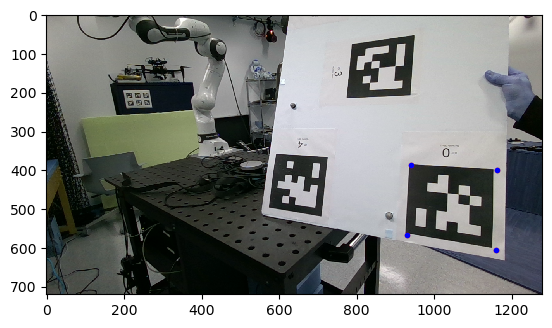

In [323]:
errors = []
for n in range(len(corners)):
# for n in range(6):
    pixel_pos = corners[n].T
    cam_p = cam_T_vicon@vicon_T_marker[n]@marker_T_tag@tag_corners
    pixel_pos_hat = K@cam_p[0:3,:]
    pixel_pos_hat = (pixel_pos_hat/pixel_pos_hat[2,:])[0:2,:]
    e = (pixel_pos-pixel_pos_hat).mean(axis=1)
    errors.append(e)
errors = np.array(errors)
plt.imshow(imgs[n])
plt.plot(pixel_pos[0,:], pixel_pos[1,:], 'r.')
plt.plot(pixel_pos_hat[0,:], pixel_pos_hat[1,:], 'b.')


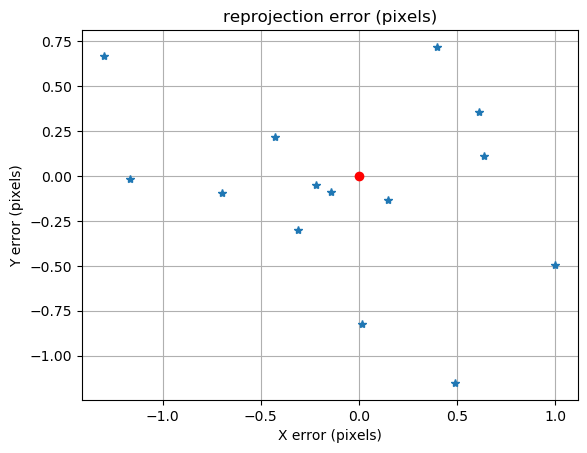

In [324]:
plt.plot(errors[:,0],errors[:,1], '*')
plt.plot([0], [0], 'ro')
plt.title('reprojection error (pixels)')
plt.xlabel('X error (pixels)')
plt.ylabel('Y error (pixels)')
plt.grid(True)